# Marketer Risk Estimation Walkthrough

This notebook demonstrates how the Monte Carlo simulations are constructed for estimating the marketer re-identification risk of different policies when sharing patient-level disease surveillance data, such as that of COVID-19. This walkthrough follows a similar pattern to that of the PK risk estimation.

In [1]:
# load libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Data
First, the disease case counts data is loaded. This example is similar to the COVID-19 daily case counts data from the Johns Hopkins University (JHU) COVID-19 surveillance data repository. The data lists the number of new disease cases reported in a county (represented by a FIPS code) per day.

In [2]:
# import disease case counts

df = pd.read_csv('example_counts_data.csv').set_index('fips')
df

,2020-01-01,2020-01-02,2020-01-03,2020-01-04,2020-01-05,2020-01-06,2020-01-07,2020-01-08,2020-01-09,2020-01-10,...,2020-04-01,2020-04-02,2020-04-03,2020-04-04,2020-04-05,2020-04-06,2020-04-07,2020-04-08,2020-04-09,2020-04-10
fips,,,,,,,,,,,,,,,,,,,,,
1,0,1,6,6,7,9,1,13,9,15,...,60,48,45,20,40,46,2,2,7,23
2,0,3,1,4,7,9,13,11,10,4,...,64,28,25,24,25,34,32,37,35,15
3,0,2,2,4,7,4,10,8,14,2,...,32,36,25,59,53,14,11,29,42,20
4,1,1,3,2,3,8,4,3,2,3,...,39,48,47,35,46,26,15,32,35,32
5,1,1,1,6,0,6,5,0,11,18,...,59,29,50,17,37,35,34,3,8,30
6,1,2,2,6,1,3,1,11,8,9,...,22,5,28,18,34,56,10,22,48,42
7,0,0,3,2,5,10,3,8,2,12,...,10,48,51,42,25,31,20,34,31,19
8,1,1,2,0,7,6,4,14,6,10,...,54,41,39,27,50,22,11,15,25,9
9,0,0,1,3,4,3,3,13,9,2,...,13,44,10,60,15,46,43,27,31,16


Next, county demographic statistics are loaded. The example data, similar to that provided by the US Census PCT12 tables, lists the age, race, sex, and ethnicity joint statistics for each county. The data is formated in the following manner:

In [3]:
# import census data

census = pd.read_csv("example_census_data.csv")
census

,fips,age,race,sex,ethnicity,counts
0,1,0,w,Male,hl,8
1,1,1,w,Male,hl,6
2,1,2,w,Male,hl,7
3,1,3,w,Male,hl,6
4,1,4,w,Male,hl,9
...,...,...,...,...,...,...
28835,10,98,mixed,Female,nh,4
28836,10,99,mixed,Female,nh,3
28837,10,100,mixed,Female,nh,18
28838,10,105,mixed,Female,nh,0


# Code

The "generalize" helper function, defined below, generalizes and formats the census data according to the generalization scheme defined by a data sharing policy. An example output of the function is shown below. The example policy generalizes age to 15-year age bins and generalizes American Indian/Alaskan Native, Native Hawaiian/Pacific Islander, Mixed race, and Some Other race into a new Other race category.

In [4]:
def generalize(df, ind_col = "fips", ages = False, races = False, sexes = False, ethnicities = False):
    """
    Generalizes census data for age, race, sex, and/or ethnicity.
    """
    temp = df.copy()
    
    # generalize bin values
    if ages:
        temp['age'] = pd.cut(temp['age'],ages, right=False) 
    if races:
        for race_gen in races:
            for key, value in race_gen.items():
                for val in value:
                    temp.loc[temp.race == val, 'race'] = key          
    if sexes:
        temp['sex'] = 'both_sex'
    if ethnicities:
        temp['ethnicity'] = 'both_ethnicity'
        
    # groupby and sum values per demographic bin
    new_temp = temp.groupby([ind_col, 'sex', 'race', 'age', 'ethnicity'])\
                    .agg({'counts':'sum'})\
                    .astype({'counts':int})\
                    .reset_index()
    # label each bin
    new_temp['bins'] = new_temp['sex'] + \
                        ',' + new_temp['race'] + \
                        ',' + new_temp['ethnicity'] + \
                        ',' + new_temp['age']\
                        .astype(str)
    
    return new_temp.pivot_table(index = ind_col, columns = 'bins', values = 'counts')

# example
generalize(census,
           ages = [0, 15, 30, 45, 60, 75, 90, 120],
           races = [{'other':['ai_an', 'nh_pi', 'other', 'mixed']}]).head()

bins,"Female,a,hl,[0, 15)","Female,a,hl,[15, 30)","Female,a,hl,[30, 45)","Female,a,hl,[45, 60)","Female,a,hl,[60, 75)","Female,a,hl,[75, 90)","Female,a,hl,[90, 120)","Female,a,nh,[0, 15)","Female,a,nh,[15, 30)","Female,a,nh,[30, 45)",...,"Male,w,hl,[60, 75)","Male,w,hl,[75, 90)","Male,w,hl,[90, 120)","Male,w,nh,[0, 15)","Male,w,nh,[15, 30)","Male,w,nh,[30, 45)","Male,w,nh,[45, 60)","Male,w,nh,[60, 75)","Male,w,nh,[75, 90)","Male,w,nh,[90, 120)"
fips,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,1313,1125,1135,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1228,1156,1089,1226,1248,1307,1081,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Finally, we define the privacy_risk_estimation_marketer class. This class is used to run multiple Monte Carlo random sampling simulations to estimate the marketer risk. The sampling is performed without replacement (dependent sampling). The marketer risk is evaluated on the cumulative simulated dataset, i.e., the marketer risk evaluated on day d is the marketer risk of sharing the cumulative dataset for disease cases reported before and on day d.

In [5]:
class privacy_risk_estimation_marketer:
    
    """
    Uses Monte Carlo sampling techniques (without replacement) to estimate the longitudinal marketer
    risk of a sharing patient-level pandemic data on a consistent basis (e.g., daily or weekly). The 
    marketer risk is estimated for each time point in a given county, when sharing data under a 
    specific data sharing policy (which defines the demographic bins). The marketer risk values are 
    calculated on the cumulative dataset over time.
    
    Input:
    counts = Dataframe of the case counts per time period (e.g. daily counts of new disease cases from
             the JHU COVID-19 surveillance data). Must include the fips code in the index and the columns
             must be date values.
    gen_census = The generalized census, i.e., the output of the generalize function above for the
                 specified fips code.
    fips = The fips code of interest. Must be of the same format of the counts dataframe index column.
    n_sims = The number of simulations to be run in the experiment.
    
    Output:
    self.marketer = Dataframe where each row is a unique simulation and each column is a time period.
                    Each cell value corresponds to each row's (simulation's) marketer risk on
                    that time period, calculated on the cumulative dataset through that time period.
    """
    
    def __init__(self, counts, gen_census, fips, n_sims, rng=np.random.default_rng()):
        
        self.counts = counts.loc[fips,:].values
        self.dates = counts.columns
        self.census = gen_census
        self.n_bins = len(self.census)
        self.marketer = pd.DataFrame(columns = self.dates)
        self.n_sims = n_sims
        self.xk = np.arange(self.n_sims)
        self.rng = rng
        self.all_cases = np.zeros((self.n_sims, self.n_bins))
        
    def create_full_population(self):
        
        """
        Creates full population from generalized census counts.
        """
        
        self.full_pop = np.tile(self.census.values, (self.n_sims,1))
        
    def get_infected_population(self):
        
        """
        Creates the infected population for each simulation.
        """
        
        ppl = self.full_pop[0]
        self.indexed_pop = np.concatenate(list(map(lambda i: np.repeat(i, ppl[i]), range(len(ppl)))),axis=0)
        
        # if more than one equivalence class, randomly choose infected from full population
        if len(self.full_pop[0]) > 1:
            self.choose_infected()
        else:
            self.choose_infected(False)
        
    def choose_infected(self, true_shuffle=True):
        
        """
        Monte Carlo random samples without replacement the infected indviduals from the population.
        """
        
        total_ppl = self.counts.sum()
        
        if true_shuffle:
            self.infected = np.stack(list(map(lambda sim: self.rng.choice(self.indexed_pop,
                                                                          size=total_ppl,
                                                                          replace=False),
                                         range(self.n_sims))), axis=0)
        else:
            row = self.indexed_pop[:total_ppl]
            self.infected = np.tile(row, (self.n_sims, 1))
            
        #del self.indexed_pop
    
    def count_per_bin(self):
            
        """
        Counts the number of infected individuals in each demographic bin for the current time
        period's infections.
        """
        
        # split shuffled values on sample size
        samples, self.infected = np.split(self.infected, [self.n_ppl], axis=1)
        
        # add new infected people per bin
        for i in samples.T:
            self.all_cases[self.xk,i] += 1
        
    def calc_marketer_risk(self):
        
        """
        Calculates the marketer risk on the cumulative simulated disease case dataset.
        """
        
        with np.errstate(divide='ignore', invalid='ignore'):
            group_ratios = np.nan_to_num(self.all_cases / self.full_pop)
        return group_ratios.sum(axis=1)/self.all_cases.sum(axis = 1)
        
    def run_full_simulation(self):
        
        """
        Runs the full simulation.
        """
        
        self.create_full_population()
        self.get_infected_population()
        
        fill_zeros = True
        
        for i in range(len(self.dates)):
            date = self.dates[i]
            self.n_ppl = self.counts[i]
            
            if fill_zeros:
                if (self.n_ppl == 0):
                    self.marketer[date] = [0] * self.n_sims
                else:
                    self.count_per_bin()
                    self.marketer[date] = self.calc_marketer_risk()
                    fill_zeros = False
                
            else:
                self.count_per_bin()
                self.marketer[date] = self.calc_marketer_risk()
        
    def get_stats(self, df, percentiles):
        
        """
        Helper function to generate summary statistics on the simulation results.
        """
        
        stats = np.percentile(df, percentiles, axis=0)
        results = pd.DataFrame()
        results['date'] = self.dates
        results['lower'] = stats[0, :]
        results['mean'] = np.mean(df, axis=0).values
        results['upper'] = stats[1, :]

        return results

# Simulation details
## Simulating who gets sick

First, we demonstrate how the Monte Carlo simulation selects who gets infected in a county. Using the generalize function, the population joint statistics are generalized into four bins: female <50 years old, females >= 50 years old, males < 50 years old, and males >= 50 years old.

In [6]:
gc = generalize(census,
                ages = [0, 50, 120],
                races = [{'all_race':['w', 'b', 'ai_an', 'a', 'nh_pi', 'other', 'mixed']}],
                sexes = False,
                ethnicities = True)

gc

bins,"Female,all_race,both_ethnicity,[0, 50)","Female,all_race,both_ethnicity,[50, 120)","Male,all_race,both_ethnicity,[0, 50)","Male,all_race,both_ethnicity,[50, 120)"
fips,,,,
1,5923,6085,6314,6122
2,5430,6221,5584,5876
3,5581,6102,5498,5975
4,5434,5804,6044,5567
5,5941,5662,5701,5992
6,16686,14676,20121,15127
7,6207,6603,6517,6255
8,5495,6024,5703,5636
9,5635,6188,5675,5794


In this example, we run 5 simulations for the example county with FIPS code 1. The generalized census data for FIPS 1 is shown above. According to the example census data, FIPS 1 5,923 females younger than 50 years old; 6,085 females 50 years and older; 6,314 males less than 50 years old; and 6,122 males 50 years and older. 

After initializing the class object, the full_pop array is created. The full_pop array keeps the numbers of full population separated by demographic group according to the policy for each simulation. In this case, the array is of size 5x4; i.e., 5 simulations and 4 demographic groups in the policy.

In [7]:
# choose county
fip = 1

# initialize class object
mc = privacy_risk_estimation_marketer(counts = df.loc[fip,:].to_frame().transpose(),
                                gen_census = gc.loc[fip,:],
                                fips = fip,
                                n_sims = 5,
                                rng = np.random.default_rng(0)) # seeded for reproducibility

# create full population for each simulation
mc.create_full_population()
mc.full_pop

array([[5923, 6085, 6314, 6122],
       [5923, 6085, 6314, 6122],
       [5923, 6085, 6314, 6122],
       [5923, 6085, 6314, 6122],
       [5923, 6085, 6314, 6122]])

Next the class an indexed population array, from which the infected individuals will be randomly sampled. Within the indexed population array, each individual is represented by the index value of their demographic group - the 5,923 females younger than 50 are represented with the value 0; the 6,085 females 50 and older are represented with the value 1; etc.

In [8]:
# create indexed population
mc.get_infected_population()

# show how many 0, 1, 2, and 3 index values are in each row.
print(pd.Series(mc.indexed_pop).value_counts())

2    6314
3    6122
1    6085
0    5923
dtype: int64


From the indexed population array, we independently sample x individuals for each simulation, where x is the total number of disease cases reported per the timeseries data. In this county, the time series contains 2,873 total reported cases. The results of each simulation are stacked into a single array. In this case, we are running five simulations, so the infected individuals array has five rows. This infected array holds all the individuals who are randomly infected throughout the time series for each simulation. The ordering of these individuals in the row will determine the order by which the individuals are reported as disease cases in the time series and are represented in the simulated dataset.

In [9]:
print("Infected array shape:", mc.infected.shape)

mc.infected

Infected array shape: (5, 2873)


array([[1, 2, 0, ..., 2, 2, 3],
       [2, 0, 3, ..., 0, 3, 3],
       [1, 2, 2, ..., 3, 1, 3],
       [3, 2, 3, ..., 3, 3, 3],
       [0, 1, 0, ..., 0, 3, 1]])

Now that we have the randomly infected population for each simulation, we can simulate when each individual is reported as a disease case. How many cases per time period is normally defined by the input time series data, but in this reduced example, we will say 1 case was reported on the first day. The simulation takes the first index value from each row of the infected array and adds it to the same row of the all_cases array. The all_cases array is the same size as the full_pop array (5x4) and holds the counts of how many disease case are reported per demographic bin through the specific time period. This differs from the PK risk estimation, where the most recent cases are maintained. Since the marketer risk is evaluated on the cumulative simulated dataset, the class object only holds the cumulative counts of reported cases of each demographic group (the all_cases array).

In [10]:
# single time period with 1 case
mc.n_ppl = 1
mc.count_per_bin()

print('all_cases:')
print(mc.all_cases)

all_cases:
[[0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]]


The first individual from the top row (or top simulation) of the infected array to get sick has index value 1. That results in one individual in the 1-index (moving from left to right) bin in the first row of the new_cases array. The counts for each cell on the other rows are counted similarly.

When individuals are infected and reported as a disease case, they are removed from the infected array and added to the new_cases array. Notice how the number of columns in the infected array has now reduced by 1:

In [11]:
print("New infected array shape:", mc.infected.shape)

New infected array shape: (5, 2872)


We continue the simulation to the next time period, which we will say has fifteen cases. Notice how the all_cases array values continue to increase.

In [12]:
# second day with 15 cases
print("Infected array shape before removing 15 more cases:", mc.infected.shape)
print()

mc.n_ppl = 15
mc.count_per_bin()

print("Infected array shape after 15 more cases:", mc.infected.shape)
print()
print('all_cases:')
print(mc.all_cases)

Infected array shape before removing 15 more cases: (5, 2872)

Infected array shape after 15 more cases: (5, 2857)

all_cases:
[[5. 5. 4. 2.]
 [3. 4. 4. 5.]
 [4. 4. 6. 2.]
 [5. 3. 3. 5.]
 [2. 4. 5. 5.]]


For consistency with the PK risk estimation walkthrough, we simulate 3 more time periods, with 10, 5, and 12 cases, respectively.

In [13]:
# 3 more days
mc.n_ppl = 10
mc.count_per_bin()
mc.n_ppl = 5
mc.count_per_bin()
mc.n_ppl = 12
mc.count_per_bin()

print("New infected array shape:", mc.infected.shape)
print()
print('all_cases:')
print(mc.all_cases)

New infected array shape: (5, 2830)

all_cases:
[[ 8. 11. 15.  9.]
 [10. 10. 13. 10.]
 [14.  8. 15.  6.]
 [10. 11. 10. 12.]
 [11.  9. 10. 13.]]


# Marketer risk calculation

Next, we show how the marketer risk is calculated. The marketer risk is calculated on each time period (e.g., every day or every week) in the simulation using the all_cases array. This measures the marketer risk on the aggregated dataset under the assumption the attacker does not use date of diagnosis in their re-identification attack.

The calculation first involves summing the fractions of small f over big F in the marketer risk equation, for each row (simulation). Small f is the size of the demographic bin in the shared dataset, and big F is the size of the demographic bin in the population.

In [14]:
print('all_cases:')
print(mc.all_cases)
print()
print('full_pop:')
print(mc.full_pop)
print()
group_ratios = (mc.all_cases/mc.full_pop).sum(axis=1) # sum over rows
print("sum over each simulation's f/F combinations:")
print(group_ratios)

all_cases:
[[ 8. 11. 15.  9.]
 [10. 10. 13. 10.]
 [14.  8. 15.  6.]
 [10. 11. 10. 12.]
 [11.  9. 10. 13.]]

full_pop:
[[5923 6085 6314 6122]
 [5923 6085 6314 6122]
 [5923 6085 6314 6122]
 [5923 6085 6314 6122]
 [5923 6085 6314 6122]]

sum over each simulation's f/F combinations:
[0.00700417 0.00702409 0.00703412 0.00703998 0.00704348]


The values are then averaged by the number of total cases. This array holds five values; the marketer risk for each simulation. The mean value of these five simulations would be the expected marketer risk, for the specific policy and specific county on for this time period.

In [15]:
group_ratios/mc.all_cases.sum(axis=1)

array([0.00016289, 0.00016335, 0.00016358, 0.00016372, 0.0001638 ])

# Full simulation example
To finish this walkthrough, we give a full example using our example data. In this example, the policy generalizes age into 15-yeare age bins [0-15), [15-30), [30-45), [45-60), [60-75), [75-90), and 90+. Sex and ethnicity are suppressed. Race is not generalized nor suppressed. This results in 49 potential demographic bins in each county, according to the policy.

In [16]:
gc = generalize(census,
                ages = [0, 15, 30, 45, 60, 75, 90, 120],
                sexes = True,
                ethnicities = True)

gc

bins,"both_sex,a,both_ethnicity,[0, 15)","both_sex,a,both_ethnicity,[15, 30)","both_sex,a,both_ethnicity,[30, 45)","both_sex,a,both_ethnicity,[45, 60)","both_sex,a,both_ethnicity,[60, 75)","both_sex,a,both_ethnicity,[75, 90)","both_sex,a,both_ethnicity,[90, 120)","both_sex,ai_an,both_ethnicity,[0, 15)","both_sex,ai_an,both_ethnicity,[15, 30)","both_sex,ai_an,both_ethnicity,[30, 45)",...,"both_sex,other,both_ethnicity,[60, 75)","both_sex,other,both_ethnicity,[75, 90)","both_sex,other,both_ethnicity,[90, 120)","both_sex,w,both_ethnicity,[0, 15)","both_sex,w,both_ethnicity,[15, 30)","both_sex,w,both_ethnicity,[30, 45)","both_sex,w,both_ethnicity,[45, 60)","both_sex,w,both_ethnicity,[60, 75)","both_sex,w,both_ethnicity,[75, 90)","both_sex,w,both_ethnicity,[90, 120)"
fips,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2464,3014,2619,2492,2591,2375,2176
2,0,0,0,0,0,0,0,1780,1918,1946,...,0,0,0,0,0,0,0,0,0,0
3,2407,2340,2210,2387,2478,2457,2111,531,510,506,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1429,1448,1269,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,1001,994,806,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,8854,10968,9191,13841,10036,4899,2063
7,0,0,0,0,0,0,0,1968,1900,2074,...,0,0,0,0,0,0,0,0,0,0
8,2402,2258,2301,2360,2374,2339,2110,519,632,556,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,1367,1375,1425,0,0,0,0,0,0,0


The simulation will uses the example data to define the disease record counts per day, estimating the risk for daily updating the surveillance dataset to be shared. We define a lagging period of three days and run 1,000 simulations. To summarize each simulation's risk values, we will take the mean and 95% quantile range each day's set of risk values.

In [17]:
%%time

# set parameters
fip = 1

# initialize object
mc = privacy_risk_estimation_marketer(counts = df.loc[fip,:].to_frame().transpose(),
                                      gen_census = gc.loc[fip,:],
                                      fips = fip,
                                      n_sims = 1000)

# run simulation
mc.run_full_simulation()

# summarize results
marketer = mc.get_stats(mc.marketer, [2.5, 97.5]).fillna(0)

CPU times: user 247 ms, sys: 17.9 ms, total: 265 ms
Wall time: 264 ms


In [18]:
marketer

,date,lower,mean,upper
0,2020-01-01,0.000000,0.000000,0.000000
1,2020-01-02,0.000332,0.000567,0.001189
2,2020-01-03,0.000383,0.000567,0.000788
3,2020-01-04,0.000426,0.000570,0.000729
4,2020-01-05,0.000456,0.000571,0.000709
...,...,...,...,...
96,2020-04-06,0.000563,0.000573,0.000583
97,2020-04-07,0.000563,0.000573,0.000583
98,2020-04-08,0.000562,0.000573,0.000583
99,2020-04-09,0.000563,0.000573,0.000583


Text(0.5, 0, 'Date')

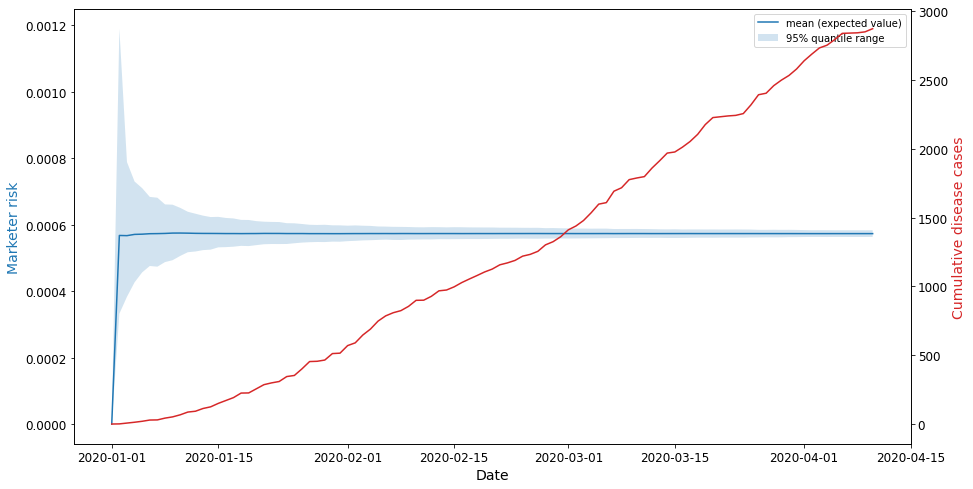

In [19]:
# plot the results
fig, ax = plt.subplots(1, 1, figsize=(15,8), sharex=True)

cases = df.loc[fip,:]
cases.index = pd.to_datetime(cases.index)

# marketer risk
ax.plot(pd.to_datetime(marketer['date']),
           marketer['mean'].values,
           label='mean (expected value)')
ax.fill_between(pd.to_datetime(marketer['date']),
                   marketer['lower'].values,
                   marketer['upper'].values,
                   alpha=0.2, label='95% quantile range')

ax2 = ax.twinx()
ax2.plot(pd.to_datetime(marketer['date']),
         cases.cumsum().values,
         color='tab:red')

ax.legend(loc='best')

ax.set_ylabel('Marketer risk',
                 color='tab:blue', fontsize=14)
ax2.set_ylabel('Cumulative disease cases', color='tab:red', fontsize=14)

ax.tick_params(labelsize='large')
ax2.tick_params(labelsize='large')

ax.set_xlabel('Date', fontsize=14)

We see that the estimated marketer risk of this policy converges to a steady value as the number of cumulative disease cases/recrods in the dataset increases.